In [4]:
from tensorflow import keras
eyesModel = keras.models.load_model('eyesOpenClose.h5')
yawnModel = keras.models.load_model('yawn.h5')

In [48]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading
import time

# Stop button
# ================
stopButton = widgets.Button(
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


# Display function
# ================
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
display_handle=display(None, display_id=True)

detector = cv2.FaceDetectorYN.create(
        'face_detection_yunet_2022mar.onnx',
        "",
        (320, 320),
        0.9, # score threshold
        0.3, # nms threshold
        5000 # top k
    )

MOUTH_LABEL_DURATION = 4 # 2
EYES_LABEL_DURATION = 4 # 2

MOUTH_CLOSE_THRESHOLD = 0.2
YAWN_DURATION = 8 # 4
YAWN_WINDOW = 120 # 45
YAWN_NUMBER = 2
YAWN_RECOVERY_PERIOD = 20 # 10

EYE_OPEN_THRESHOLD = 0.2
EYE_CLOSE_DURATION = 8 # 4
EYE_DROWSINESS_WINDOW = 120 # 45
EYE_DROP_WINDOW = 4 # 2
EYE_DROP_THRESHOLD = 0.3
EYE_DROP_NUMBER = 3
EYE_DROP_RECOVERY_PERIOD = 10 # 5

start_time = time.perf_counter()
def view(button):
    yawn_preds, eyes_preds = [], []
    yawn_pred_average, eye_pred_averages = 0, []
    yawns, eye_drops = [], []
    yawn_recovery, eye_drop_recovery = 0, 0
    yawning, closing_eyes = False, False
    while True:
        _, frame = cap.read()
        detector.setInputSize((frame.shape[1], frame.shape[0]))
        frame = cv2.flip(frame, 1)
        
        faces = detector.detect(frame)[1]
        eyes = []
        
        face_boxes = []
        if faces is not None:
            for face in faces:
                x,y,w,h = face[:4].astype('int')
                face_boxes.append([x,y,x+w,y+h])
                
            lx,ly,la,lb = sorted([[x,y,a,b,(a-x)*(b-y)] for x,y,a,b in face_boxes], key=lambda x: x[4])[-1][:-1]
            face_array = frame[max(0,ly-25):min(lb+25,frame.shape[0]), max(0,lx-25):min(la+25,frame.shape[1])]
            face_array = cv2.resize(face_array, (100,100)).reshape(-1, 100, 100, 3)
            
            yawn_pred = yawnModel.predict(face_array/255, verbose=0).item()
            yawn_preds.append(yawn_pred)
            eyes_pred = eyesModel.predict(face_array/255, verbose=0).item()
            eyes_preds.append(eyes_pred)
            
            yawn_text = "Mouth: Open" if len(yawn_preds) >= MOUTH_LABEL_DURATION and np.mean(yawn_preds[-MOUTH_LABEL_DURATION:]) < MOUTH_CLOSE_THRESHOLD else "Mouth: Closed"
            cv2.putText(frame, yawn_text, (frame.shape[1]-250,frame.shape[0]-50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            eyes_text = "Eyes: Closed" if len(eyes_preds) >= EYES_LABEL_DURATION and np.mean(eyes_preds[-EYES_LABEL_DURATION:]) < EYE_OPEN_THRESHOLD else "Eyes: Open"
            cv2.putText(frame, eyes_text, (25,frame.shape[0]-50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            frame = cv2.rectangle(frame, (lx, ly), (la, lb), (0, 255, 0), 2)
            _, frame = cv2.imencode('.jpeg', frame)
            display_handle.update(Image(data=frame.tobytes()))
            
            if len(yawn_preds) >= YAWN_DURATION:
                yawn_pred_average = np.mean(yawn_preds[-YAWN_DURATION:])
                if yawn_pred_average < MOUTH_CLOSE_THRESHOLD and yawn_recovery == 0:
                    yawns.append(1)
                    yawn_recovery = YAWN_RECOVERY_PERIOD
                else:
                    yawns.append(0)
                if len(yawns) > YAWN_WINDOW:
                    yawns = yawns[1:]
                if sum(yawns) >= YAWN_NUMBER:
                    print("ALERT!!!")
                    closer(stopButton)
            if len(eyes_preds) >= EYE_CLOSE_DURATION:
                eye_pred_averages.append(np.mean(eyes_preds[-EYE_CLOSE_DURATION:]))
                drop_window = eye_pred_averages[max(0,len(eye_pred_averages)-EYE_DROP_WINDOW-1):]
                drop = max(drop_window) - min(drop_window)
                if drop >= EYE_DROP_THRESHOLD and eye_drop_recovery == 0:
                    eye_drops.append(1)
                    eye_drop_recovery = EYE_DROP_RECOVERY_PERIOD
                else:
                    eye_drops.append(0)
                if len(eye_drops) > EYE_DROWSINESS_WINDOW:
                    eye_drops = eye_drops[1:]
                if sum(eye_drops) >= EYE_DROP_NUMBER:
                    print("ALERT!!!")
                    closer(stopButton)
            
        if yawn_recovery > 0:
            yawn_recovery -= 1
        if eye_drop_recovery > 0:
            eye_drop_recovery -= 1            
            
def closer(b):
    print(time.perf_counter()-start_time, len(eyes_preds))
#     plt.plot(eyes_preds, label='eyes')
#     plt.plot(yawn_preds, label='mouth')
#     plt.plot([np.mean(yawn_preds[i:i+10]) for i in range(len(yawn_preds))])
#     plt.show()
    cap.release()
    display_handle.update(None)
            
stopButton.on_click(closer)
            
# Run
# ================
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

None

Button(button_style='danger', description='Stop', icon='square', style=ButtonStyle(), tooltip='Description')

0.0
0.12485820801521186
0.2498194583604345
0.3747825202081003
EYE_DROP
0.4929488244015374
0.36809061638632556
0.2431293660411029
0.1181663041934371
0.12491832231171429
0.24985423988255206
0.37482799230201636
0.49973777504783357
0.40706188404146815
0.28212479672947666
0.24976588758727303
0.3746968004561495
EYE_DROP
0.4995957840947085
0.3749490731788683
0.250028223512345
0.12509731064346852
0.08600501716136932
0.21081768230942544
0.3357591775347828
0.4601261932111811
0.37699029522627825
0.25217763007822214
0.2497462098235701
0.37467396176180046
EYE_DROP
ALERT!!!
7.756683700001304 0


Exception in thread Thread-39:
Traceback (most recent call last):
  File "C:\Users\fgpac\anaconda3\envs\bhacks\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\Users\fgpac\anaconda3\envs\bhacks\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\fgpac\AppData\Local\Temp\ipykernel_23284\424857726.py", line 62, in view
AttributeError: 'NoneType' object has no attribute 'shape'


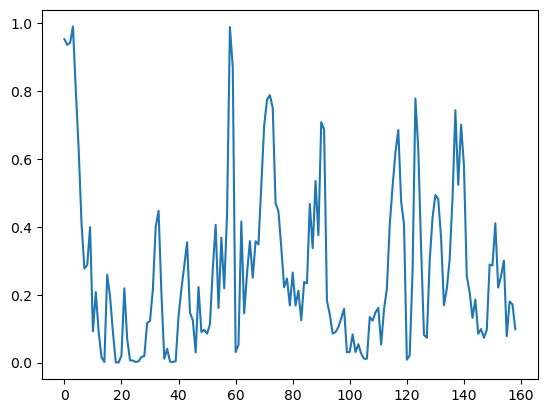